In [ ]:
# Clear GPU memory
import gc
import torch

# Delete any existing models
try:
    del model
    del base_model
    del trainer
except:
    pass

# Clear GPU cache
gc.collect()
torch.cuda.empty_cache()

print("Memory cleared!")

In [ ]:
!pip install transformers accelerate bitsandbytes datasets peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 45.8 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

model_name = "Qwen/Qwen2.5-1.5B"

# Load dataset
train_data = load_dataset("json", data_files="train.jsonl", split="train")
val_data = load_dataset("json", data_files="val.jsonl", split="train")

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

# Prepare model for training
model = prepare_model_for_kbit_training(model)

# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

# Apply LoRA
model = get_peft_model(model, peft_config)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Format function
def format_example(example):
    return f"Instruction: {example['instruction']}\nAnswer: {example['output']}"

# Training arguments
training_args = TrainingArguments(
    output_dir="./qwen2.5-1.5b-kids-ft",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=6,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=200,
    bf16=True,
    report_to="none",
)

# Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    formatting_func=format_example,
    args=training_args,
)

trainer.train()

# Save model and tokenizer
trainer.save_model("./qwen2.5-1.5b-kids-ft")
tokenizer.save_pretrained("./qwen2.5-1.5b-kids-ft")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:2111: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/1897 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/1897 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1897 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1897 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,1.215100,1.064725
100,1.015800,0.990865
150,0.819100,1.006413
200,0.693500,0.982452
250,0.649100,1.096025
300,0.503900,1.036311
350,0.499700,1.044295
400,0.413200,1.157432
450,0.413600,1.161713
500,0.381000,1.244044


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


KeyboardInterrupt: 

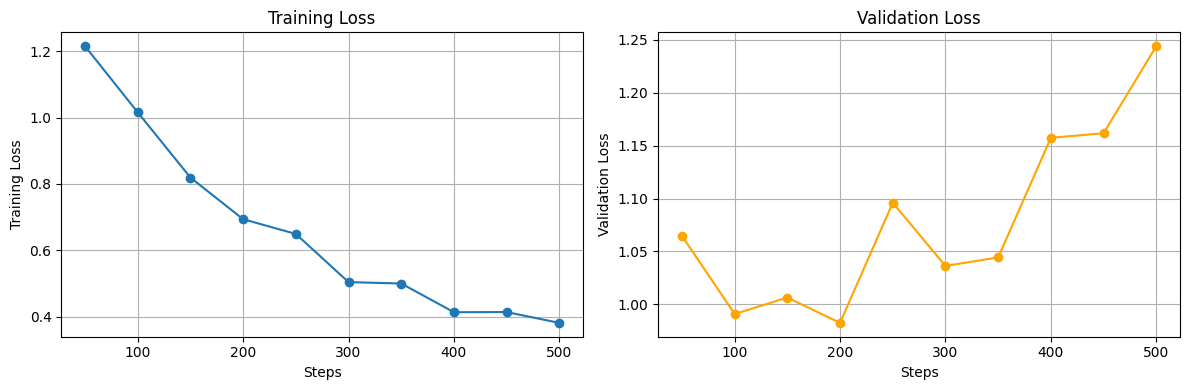

Final Training Loss: 0.3810
Final Validation Loss: 1.2440
Best Validation Loss: 0.9825


In [ ]:
# After training, view the results
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(trainer.state.log_history)

train_logs = history[history['loss'].notna()]
eval_logs = history[history['eval_loss'].notna()]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_logs['step'], train_logs['loss'], marker='o')
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eval_logs['step'], eval_logs['eval_loss'], marker='o', color='orange')
plt.xlabel('Steps')
plt.ylabel('Validation Loss')
plt.title('Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_logs['loss'].iloc[-1]:.4f}")
print(f"Final Validation Loss: {eval_logs['eval_loss'].iloc[-1]:.4f}")
print(f"Best Validation Loss: {eval_logs['eval_loss'].min():.4f}")

In [ ]:
# zip an ddownload the model
import shutil

shutil.make_archive('my_qwen_model', 'zip', './qwen2.5-1.5b-kids-ft')

from google.colab import files
files.download('my_qwen_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

print("Checking directory structure...\n")

# Check main output directory
print("Contents of ./qwen2.5-1.5b-kids-ft-continued/:")
if os.path.exists("./qwen2.5-1.5b-kids-ft-continued/"):
    print(os.listdir("./qwen2.5-1.5b-kids-ft-continued/"))
else:
    print("Directory not found!")

print("\n" + "="*80 + "\n")

# Check if checkpoint (example checkpoint-200) exists
print("Contents of ./qwen2.5-1.5b-kids-ft-continued/checkpoint-200/:")
if os.path.exists("./qwen2.5-1.5b-kids-ft-continued/checkpoint-200/"):
    print(os.listdir("./qwen2.5-1.5b-kids-ft-continued/checkpoint-200/"))
else:
    print("Directory not found!")

print("\n" + "="*80 + "\n")

# Check original model
print("Contents of ./qwen2.5-1.5b-kids-ft/:")
if os.path.exists("./qwen2.5-1.5b-kids-ft/"):
    print(os.listdir("./qwen2.5-1.5b-kids-ft/"))
else:
    print("Directory not found!")

Checking directory structure...

Contents of ./qwen2.5-1.5b-kids-ft-continued/:
Directory not found!


Contents of ./qwen2.5-1.5b-kids-ft-continued/checkpoint-200/:
Directory not found!


Contents of ./qwen2.5-1.5b-kids-ft/:
['README.md', 'checkpoint-200', 'checkpoint-400']


In [ ]:
# OPtional: If running on colab with new session then place the model in working directory and unzip.
!unzip /content/my_qwen_model.zip

Archive:  /content/my_qwen_model.zip
   creating: checkpoint-200/
   creating: checkpoint-400/
  inflating: README.md               
  inflating: checkpoint-200/tokenizer_config.json  
  inflating: checkpoint-200/README.md  
  inflating: checkpoint-200/chat_template.jinja  
  inflating: checkpoint-200/tokenizer.json  
  inflating: checkpoint-200/adapter_config.json  
  inflating: checkpoint-200/trainer_state.json  
  inflating: checkpoint-200/training_args.bin  
  inflating: checkpoint-200/vocab.json  
  inflating: checkpoint-200/rng_state.pth  
  inflating: checkpoint-200/scheduler.pt  
  inflating: checkpoint-200/added_tokens.json  
  inflating: checkpoint-200/optimizer.pt  
  inflating: checkpoint-200/special_tokens_map.json  
  inflating: checkpoint-200/adapter_model.safetensors  
  inflating: checkpoint-200/merges.txt  
  inflating: checkpoint-400/tokenizer_config.json  
  inflating: checkpoint-400/README.md  
  inflating: checkpoint-400/chat_template.jinja  
  inflating: checkpoi

In [6]:
import json
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Path to your fine-tuned model checkpoint
finetuned_model_path = r"/content/checkpoint-200"

# Path to original Qwen model
original_model_path = "Qwen/Qwen2.5-1.5B"

print("Loading models...")

# Load fine-tuned model + tokenizer
print("Loading fine-tuned model...")
finetuned_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)
finetuned_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Load original Qwen model + tokenizer
print("Loading original Qwen 2.5 1.5B model...")
original_tokenizer = AutoTokenizer.from_pretrained(original_model_path)
original_model = AutoModelForCausalLM.from_pretrained(
    original_model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Set pad_token to avoid warning messages
if finetuned_tokenizer.pad_token is None:
    finetuned_tokenizer.pad_token = finetuned_tokenizer.eos_token
if original_tokenizer.pad_token is None:
    original_tokenizer.pad_token = original_tokenizer.eos_token

print("Models loaded successfully!\n")

# Load test dataset
test_data = load_dataset("json", data_files={"test": "test.jsonl"})["test"]

def generate_answer(instruction, model, tokenizer):
    prompt = f"Instruction: {instruction}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.2,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )

    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the answer part (after "Answer:")
    if "Answer:" in full_response:
        return full_response.split("Answer:")[-1].strip()
    return full_response

print("Running evaluation...\n")

# Evaluate both models
original_correct = 0
finetuned_correct = 0
total = 0

for item in test_data:
    instruction = item["instruction"]
    expected = item["output"]

    # Generate predictions from both models
    original_prediction = generate_answer(instruction, original_model, original_tokenizer)
    finetuned_prediction = generate_answer(instruction, finetuned_model, finetuned_tokenizer)

    # Basic correctness check
    expected_keyword = expected.split()[0].lower()

    if expected_keyword in original_prediction.lower():
        original_correct += 1
    if expected_keyword in finetuned_prediction.lower():
        finetuned_correct += 1

    total += 1

original_accuracy = original_correct / total * 100
finetuned_accuracy = finetuned_correct / total * 100

print(f"Original Model Accuracy (keyword match): {original_accuracy:.2f}%")
print(f"Fine-tuned Model Accuracy (keyword match): {finetuned_accuracy:.2f}%")
print(f"Improvement: {finetuned_accuracy - original_accuracy:.2f}%\n")

# Show sample predictions in table format
print("=" * 100)
print(f"{'Instruction':<40} {'Without Fine-tuning':<30} {'After Fine-tuning':<30}")
print("=" * 100)

for i in range(min(5, len(test_data))):
    item = test_data[i]
    instruction = item["instruction"]

    original_pred = generate_answer(instruction, original_model, original_tokenizer)
    finetuned_pred = generate_answer(instruction, finetuned_model, finetuned_tokenizer)

    print("instruction: ", instruction)
    print("actual pred: ", original_pred)
    print("finetuned_pred: ", finetuned_pred)
    print("="*100)

print("=" * 100)

Loading models...
Loading fine-tuned model...


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/392 [00:00<?, ?it/s]

Loading original Qwen 2.5 1.5B model...


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Models loaded successfully!

Running evaluation...

Original Model Accuracy (keyword match): 85.32%
Fine-tuned Model Accuracy (keyword match): 92.46%
Improvement: 7.14%

Instruction                              Without Fine-tuning            After Fine-tuning             
instruction:  Can I climb the fence?
actual pred:  No, you cannot climb the fence. It is a no-go zone.
finetuned_pred:  Climbing fences is unsafe because they can tip over. It’s better to stay on the ground.
instruction:  What is a clock face?
actual pred:  A clock face is a circular device used to measure time. It typically has 12 numbers (1-12) evenly spaced around the circumference, with each number representing a specific time interval. The numbers are usually arranged in a clockwise direction, with the number 12 at the top and the number 1 at the bottom. The clock face also has a long hand (the hour hand) and a short hand (the minute hand) that move around the clock face to indicate the current
finetuned_pred:  A